# Sentiment Classification of LGBT Posts in Spanish

This notebook performs sentiment classification of Reddit posts related to the LGBT community in Spanish. The task is to classify posts into three sentiment categories:
- Negative (NEG), encoded as 0
- Neutral (NEU), encoded as 1
- Positive (POS), encoded as 2

The data has an imbalance with the ratio NEG:NEU:POS = 4:6:2

## Cell 1: Loading the Data

We'll load both the training data (`train.csv`) and development data (`dev.csv`) for model evaluation.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score
import pickle
import re
import string
import warnings
warnings.filterwarnings('ignore')

# Set paths to the data files
train_path = 'train.csv'
dev_path = 'dev.csv'

# Load the datasets
train_df = pd.read_csv(train_path)
dev_df = pd.read_csv(dev_path)

print(f"Train data shape: {train_df.shape}")
print(f"Dev data shape: {dev_df.shape}")

# Display first few rows of the training data
train_df.head()

Train data shape: (5767, 5)
Dev data shape: (1443, 5)


,id,country,keyword,post content,label
0,A4184,Argentina,travesti,¿Un `travesti`? Fija que es parte de la campañ...,NEU
1,A3962,Argentina,travesti,El `travesti` era el comisario y el conductor ...,NEU
2,A0321,Argentina,bisexuales,"Si, amigos y parejas amigas. Tanto homosexuale...",POS
3,A1258,Argentina,lesbiana,es `lesbiana` ensima,NEU
4,A3307,Argentina,transexuales,"Es que no es respetar su nombre, es como dijo ...",NEG


Label distribution in training set:
label
NEU    3174
NEG    1960
POS     633
Name: count, dtype: int64

Label distribution in dev set:
label
NEU    888
NEG    475
POS     80
Name: count, dtype: int64


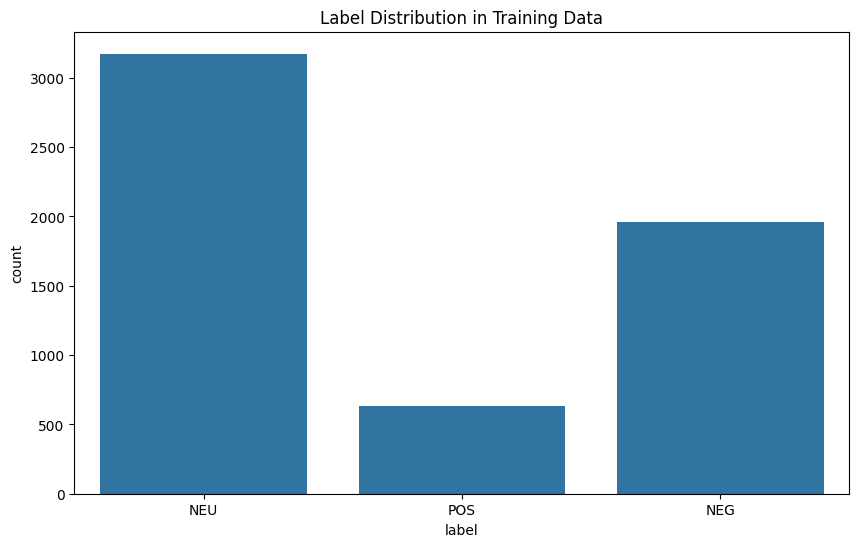

In [2]:
# Map the labels to numerical values
label_map = {'NEG': 0, 'NEU': 1, 'POS': 2}

# Apply the mapping
train_df['label_encoded'] = train_df['label'].map(label_map)
dev_df['label_encoded'] = dev_df['label'].map(label_map)

# Check the distribution of labels in the training set
print("Label distribution in training set:")
print(train_df['label'].value_counts())
print("\nLabel distribution in dev set:")
print(dev_df['label'].value_counts())

# Visualize the distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='label')
plt.title('Label Distribution in Training Data')
plt.show()

## Cell 2: Preprocessing the Text Data

We'll process the text data by:
1. Converting emojis to meaningful words
2. Creating a dictionary for emoticons
3. Removing special characters and URLs
4. Converting text to lowercase
5. Removing stopwords (optional)

In [3]:
# Install required libraries if not already installed
# !pip install emoji spacy nltk

# Import additional preprocessing libraries
import emoji
import nltk
from nltk.corpus import stopwords
import spacy

# Download necessary NLTK data
nltk.download('stopwords')
spanish_stopwords = stopwords.words('spanish')

# Load Spanish language model for spaCy
try:
    nlp = spacy.load('es_core_news_sm')
except:
    !python -m spacy download es_core_news_sm
    nlp = spacy.load('es_core_news_sm')

# Define a dictionary of common emoticons
emoticon_dict = {
    ':)': 'sonrisa',
    ':(': 'triste',
    ':D': 'risa',
    ':-D': 'risa',
    ':P': 'sacando_lengua',
    ':-P': 'sacando_lengua',
    ':p': 'sacando_lengua',
    ':-p': 'sacando_lengua',
    ';)': 'guiño',
    ':-|': 'serio',
    ':|': 'serio',
    ':o': 'sorprendido',
    ':O': 'sorprendido',
    ':-o': 'sorprendido',
    ':-O': 'sorprendido',
    ':/': 'escéptico',
    ':-/': 'escéptico',
    ':S': 'confundido',
    ':s': 'confundido',
    ':-S': 'confundido',
    ':-s': 'confundido',
    '<3': 'amor',
    '</3': 'corazón_roto',
    ':*': 'beso',
    ':-*': 'beso',
    'xD': 'carcajada',
    'XD': 'carcajada',
    'x-D': 'carcajada',
    'X-D': 'carcajada'
}

def preprocess_text(text):
    # Handle NaN values
    if pd.isna(text):
        return ""
    
    # Convert to string (just in case)
    text = str(text)
    
    # Convert emojis to words
    text = emoji.demojize(text)
    
    # Replace emoticons with their meaning
    for emoticon, meaning in emoticon_dict.items():
        text = text.replace(emoticon, f" {meaning} ")
    
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and keep only letters, numbers, and spaces
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply preprocessing to both datasets
train_df['processed_text'] = train_df['post content'].apply(preprocess_text)
dev_df['processed_text'] = dev_df['post content'].apply(preprocess_text)

# Look at a few examples of processed text
print("Original vs. Processed Text Examples:")
for i in range(3):
    print(f"Original: {train_df.iloc[i]['post content'][:100]}...")
    print(f"Processed: {train_df.iloc[i]['processed_text'][:100]}...\n")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Original vs. Processed Text Examples:
Original: ¿Un `travesti`? Fija que es parte de la campaña **"No te comas el verso, come de verdad"**...
Processed: un travesti fija que es parte de la campaña no te comas el verso come de verdad...

Original: El `travesti` era el comisario y el conductor del auto la bicicleta....
Processed: el travesti era el comisario y el conductor del auto la bicicleta...

Original: Si, amigos y parejas amigas. Tanto homosexuales como `bisexuales`. S'all cool. 

- Como nacio la ami...
Processed: si amigos y parejas amigas tanto homosexuales como bisexuales s all cool como nacio la amistad mejor...



## Cell 3: Feature Extraction

We'll transform the text into features using different techniques:
1. Bag of Words (BoW)
2. TF-IDF with n-grams
3. Word2Vec embeddings

In [4]:
# Install gensim for Word2Vec
# !pip install gensim

from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# 1. Bag of Words (BoW)
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(train_df['processed_text'])
X_dev_bow = bow_vectorizer.transform(dev_df['processed_text'])

print(f"BoW features shape for training data: {X_train_bow.shape}")
print(f"BoW features shape for dev data: {X_dev_bow.shape}")

# 2. TF-IDF with n-grams
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['processed_text'])
X_dev_tfidf = tfidf_vectorizer.transform(dev_df['processed_text'])

print(f"TF-IDF features shape for training data: {X_train_tfidf.shape}")
print(f"TF-IDF features shape for dev data: {X_dev_tfidf.shape}")

# 3. Word2Vec Embeddings
# Tokenize the text
train_tokens = [text.split() for text in train_df['processed_text']]
dev_tokens = [text.split() for text in dev_df['processed_text']]
all_tokens = train_tokens + dev_tokens

# Train Word2Vec model
w2v_model = Word2Vec(sentences=all_tokens, vector_size=100, window=5, min_count=1, workers=4)

# Function to get document vectors from Word2Vec
def document_vector(doc, model):
    doc = [word for word in doc if word in model.wv.key_to_index]
    if len(doc) > 0:
        return np.mean([model.wv[word] for word in doc], axis=0)
    else:
        return np.zeros(model.vector_size)

# Get document vectors for training and dev sets
X_train_w2v = np.array([document_vector(doc, w2v_model) for doc in train_tokens])
X_dev_w2v = np.array([document_vector(doc, w2v_model) for doc in dev_tokens])

print(f"Word2Vec features shape for training data: {X_train_w2v.shape}")
print(f"Word2Vec features shape for dev data: {X_dev_w2v.shape}")

# Extract target variables
y_train = train_df['label_encoded'].values
y_dev = dev_df['label_encoded'].values

# Create a dictionary to store all feature representations
feature_sets = {
    'bow': (X_train_bow, X_dev_bow),
    'tfidf': (X_train_tfidf, X_dev_tfidf),
    'word2vec': (X_train_w2v, X_dev_w2v)
}

BoW features shape for training data: (5767, 5000)
BoW features shape for dev data: (1443, 5000)
TF-IDF features shape for training data: (5767, 5000)
TF-IDF features shape for dev data: (1443, 5000)
Word2Vec features shape for training data: (5767, 100)
Word2Vec features shape for dev data: (1443, 100)


## Cell 4: Handling Data Imbalance

Handle data imbalance by setting class weights for the minority classes. The label ratio in the training data is NEG:NEU:POS = 4:6:2, so we'll adjust the weights accordingly.

Class weights: {0: 0.98078231292517, 1: 0.6056500735139676, 2: 3.036861506055819}
Custom class weights: {0: 1.5, 1: 1.0, 2: 3.0}


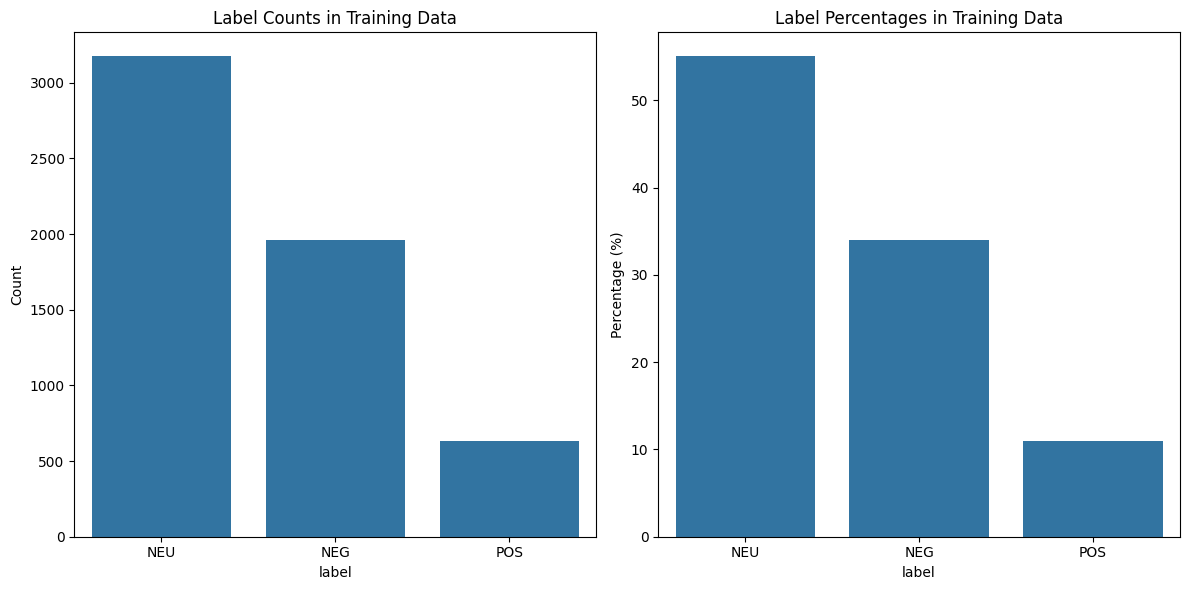

In [5]:
# Calculate class weights based on the inverse frequency
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert to dictionary format
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class weights:", class_weight_dict)

# We can also create custom class weights based on the known ratio (4:6:2)
custom_class_weight = {0: 1.5, 1: 1.0, 2: 3.0}  # Adjusted based on the inverse of class frequencies
print("Custom class weights:", custom_class_weight)

# Visualize the distribution again with both count and percentage
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
counts = train_df['label'].value_counts()
sns.barplot(x=counts.index, y=counts.values)
plt.title('Label Counts in Training Data')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
percentages = train_df['label'].value_counts(normalize=True) * 100
sns.barplot(x=percentages.index, y=percentages.values)
plt.title('Label Percentages in Training Data')
plt.ylabel('Percentage (%)')

plt.tight_layout()
plt.show()

## Cell 5: Model Training and Hyperparameter Tuning

We'll train multiple models with different feature representations and use GridSearchCV for hyperparameter tuning.

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Define models with their parameter grids
models = {
    'LogisticRegression': (LogisticRegression(max_iter=1000), {
        'C': [0.1, 1, 10],
        'solver': ['liblinear', 'saga'],
        'class_weight': ['balanced', custom_class_weight, None]
    }),
    
    'SVC': (SVC(), {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto'],
        'class_weight': ['balanced', custom_class_weight, None]
    }),
    
    'MultinomialNB': (MultinomialNB(), {
        'alpha': [0.1, 0.5, 1.0]
    }),
    
    'DecisionTree': (DecisionTreeClassifier(), {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'class_weight': ['balanced', custom_class_weight, None]
    }),
    
    'RandomForest': (RandomForestClassifier(), {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'class_weight': ['balanced', custom_class_weight, None]
    })
}

# Dictionary to store trained models
trained_models = {}

# Train models for each feature representation
for feature_name, (X_train, X_dev) in feature_sets.items():
    print(f"\nTraining models with {feature_name} features...")
    
    feature_models = {}
    
    # Skip MultinomialNB for Word2Vec as it requires non-negative features
    if feature_name == 'word2vec':
        models_to_use = {k: v for k, v in models.items() if k != 'MultinomialNB'}
    else:
        models_to_use = models
    
    for model_name, (model, param_grid) in models_to_use.items():
        print(f"Training {model_name}...")
        
        # Setup grid search
        grid = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=5,  # 5-fold cross-validation
            scoring='f1_macro',  # use F1-macro to handle imbalanced classes
            n_jobs=-1  # Use all available processors
        )
        
        # Fit the grid search
        grid.fit(X_train, y_train)
        
        # Save best model
        feature_models[model_name] = grid.best_estimator_
        
        print(f"Best parameters: {grid.best_params_}")
        print(f"Best cross-validation score: {grid.best_score_:.4f}")
        
    trained_models[feature_name] = feature_models


Training models with bow features...
Training LogisticRegression...
Best parameters: {'C': 0.1, 'class_weight': {0: 1.5, 1: 1.0, 2: 3.0}, 'solver': 'saga'}
Best cross-validation score: 0.4323
Training SVC...
Best parameters: {'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.4206
Training MultinomialNB...
Best parameters: {'alpha': 0.5}
Best cross-validation score: 0.4079
Training DecisionTree...
Best parameters: {'class_weight': None, 'max_depth': None, 'min_samples_split': 2}
Best cross-validation score: 0.3727
Training RandomForest...
Best parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score: 0.3964

Training models with tfidf features...
Training LogisticRegression...
Best parameters: {'C': 1, 'class_weight': {0: 1.5, 1: 1.0, 2: 3.0}, 'solver': 'saga'}
Best cross-validation score: 0.4351
Training SVC...
Best parameters: {'C': 1, 'class_weight': 'balanc

## Cell 6: Evaluation Metrics

Evaluate all models on the dev set and calculate recall, accuracy, F1-macro, and F1-samples.

In [7]:
# Dictionary to store evaluation results
evaluation_results = {}

for feature_name, models_dict in trained_models.items():
    print(f"\nEvaluating models trained with {feature_name} features on the dev set:")
    
    # Get the corresponding feature representations for the dev set
    X_dev = feature_sets[feature_name][1]
    
    feature_results = {}
    
    for model_name, model in models_dict.items():
        # Make predictions
        y_pred = model.predict(X_dev)
        
        # Calculate evaluation metrics
        accuracy = accuracy_score(y_dev, y_pred)
        recall = recall_score(y_dev, y_pred, average='macro')
        f1_macro = f1_score(y_dev, y_pred, average='macro')
        # f1_samples = f1_score(y_dev, y_pred, average='samples')
        
        # Store results
        feature_results[model_name] = {
            'accuracy': accuracy,
            'recall': recall,
            'f1_macro': f1_macro,
            # 'f1_samples': f1_samples,
            'confusion_matrix': confusion_matrix(y_dev, y_pred),
            'classification_report': classification_report(y_dev, y_pred)
        }
        
        print(f"\n{model_name} Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-macro: {f1_macro:.4f}")
        # print(f"F1-samples: {f1_samples:.4f}")
        print("\nConfusion Matrix:")
        print(confusion_matrix(y_dev, y_pred))
        print("\nClassification Report:")
        print(classification_report(y_dev, y_pred))
        
    evaluation_results[feature_name] = feature_results


Evaluating models trained with bow features on the dev set:

LogisticRegression Results:
Accuracy: 0.5059
Recall: 0.4011
F1-macro: 0.3879

Confusion Matrix:
[[215 210  50]
 [306 500  82]
 [ 31  34  15]]

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.45      0.42       475
           1       0.67      0.56      0.61       888
           2       0.10      0.19      0.13        80

    accuracy                           0.51      1443
   macro avg       0.39      0.40      0.39      1443
weighted avg       0.55      0.51      0.52      1443


SVC Results:
Accuracy: 0.5170
Recall: 0.4056
F1-macro: 0.3958

Confusion Matrix:
[[222 221  32]
 [305 510  73]
 [ 29  37  14]]

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.47      0.43       475
           1       0.66      0.57      0.62       888
           2       0.12      0.17      0.14        80

    accuracy         

## Cell 7: Visualization of Results

Create visualizations of the evaluation metrics and confusion matrices for all models.

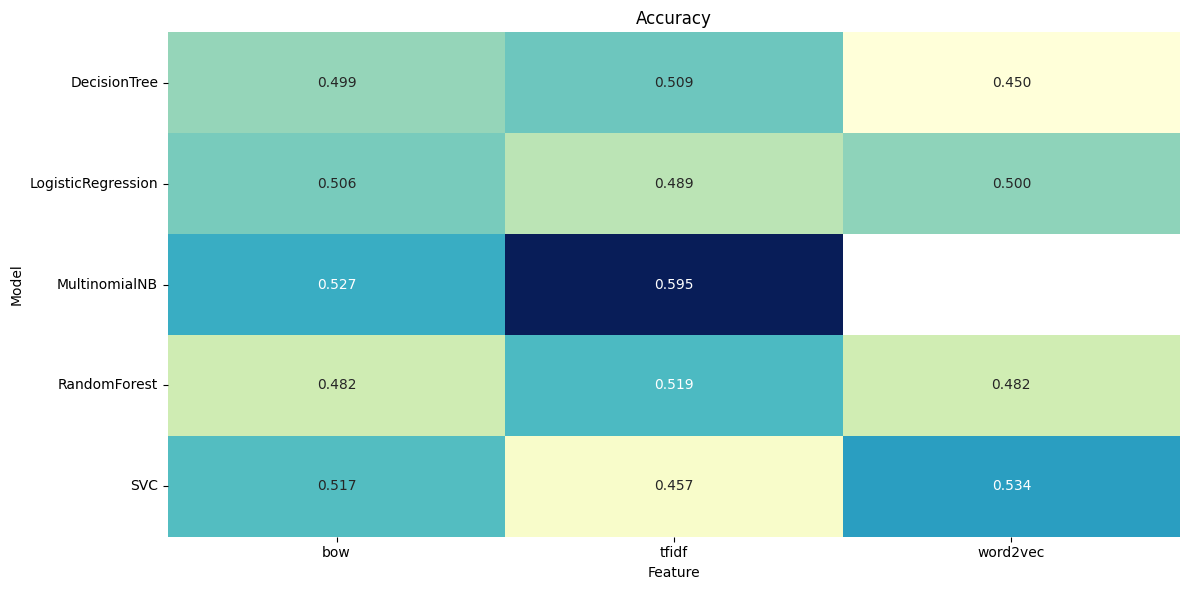

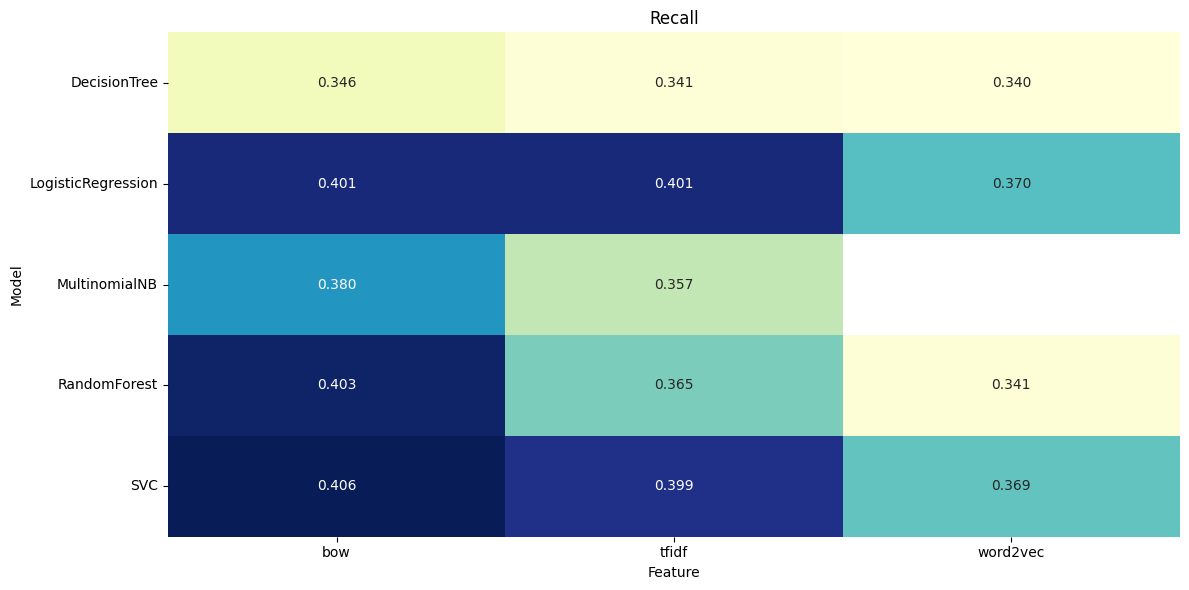

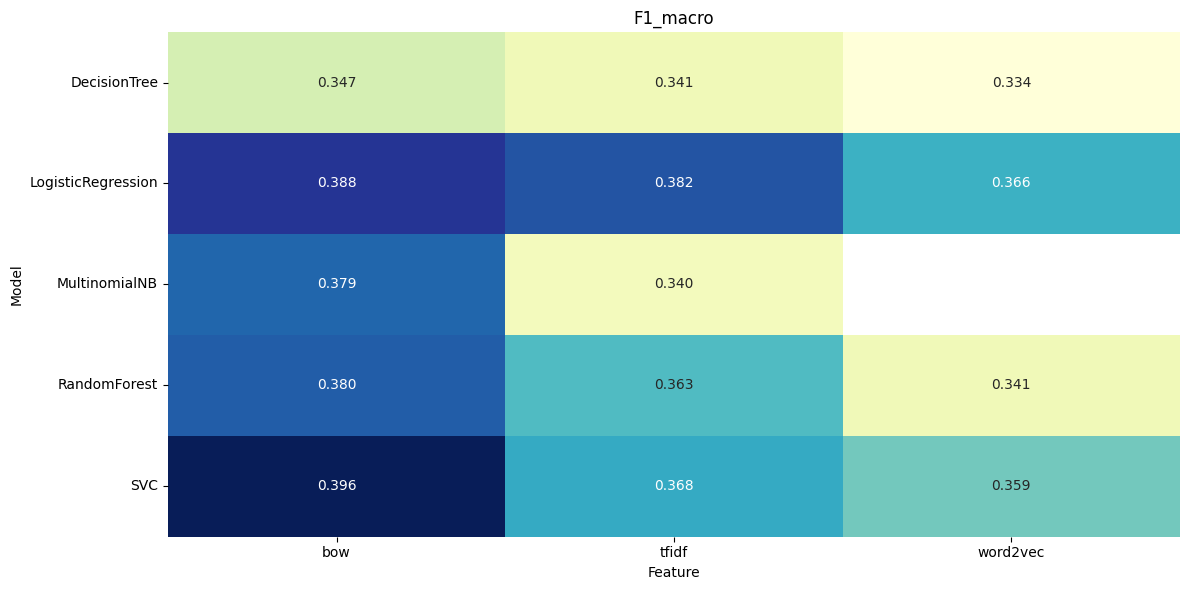

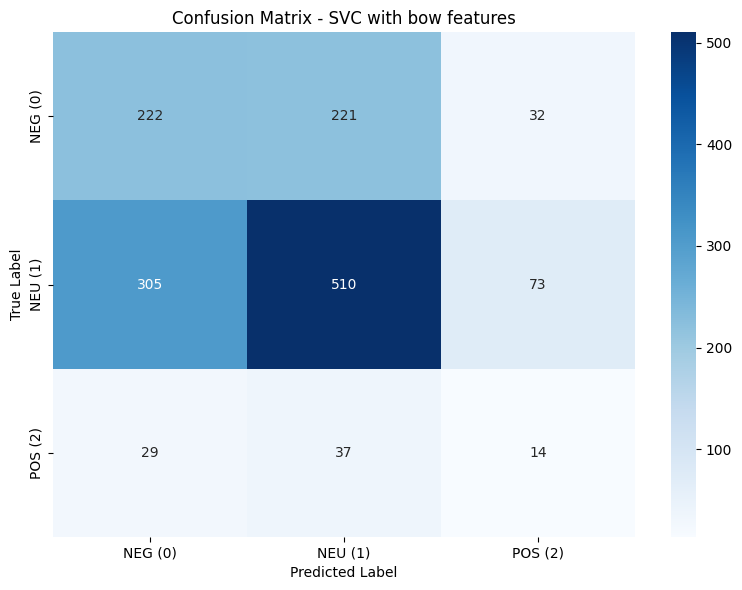

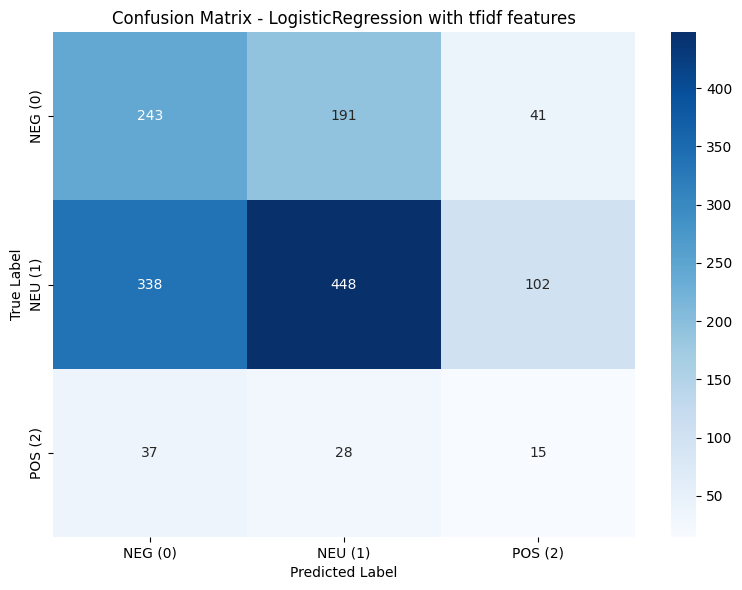

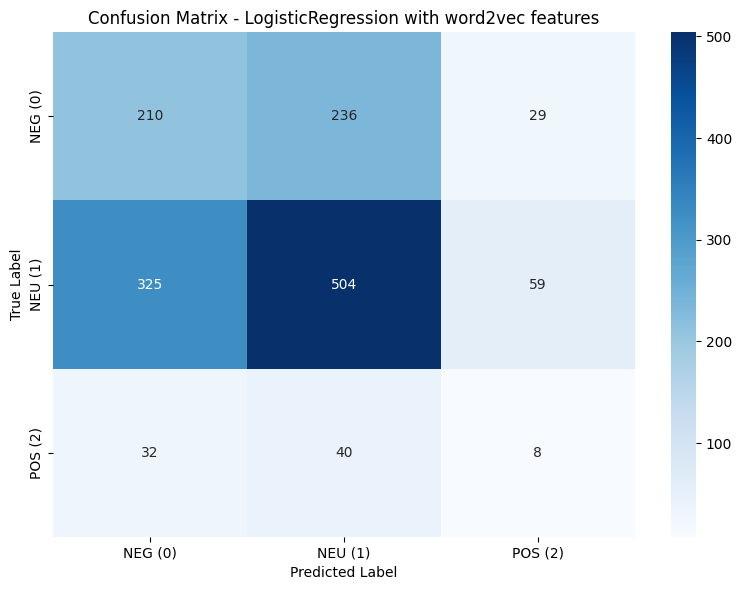

In [8]:
# Plot evaluation metrics for all models across feature types
metrics = ['accuracy', 'recall', 'f1_macro']
feature_names = list(evaluation_results.keys())

# Create separate plots for each metric
for metric in metrics:
    plt.figure(figsize=(12, 6))
    
    # Create a dataframe for plotting
    metric_data = []
    model_list = []
    feature_list = []
    value_list = []
    
    for feature_name in feature_names:
        for model_name, results in evaluation_results[feature_name].items():
            model_list.append(model_name)
            feature_list.append(feature_name)
            value_list.append(results[metric])
    
    df = pd.DataFrame({
        'Model': model_list,
        'Feature': feature_list,
        'Value': value_list
    })
    
    # Create a pivot table for the heatmap
    pivot_df = df.pivot(index='Model', columns='Feature', values='Value')
    
    # Create heatmap
    sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', fmt='.3f', cbar=False)
    plt.title(f'{metric.capitalize()}')
    plt.tight_layout()
    plt.show()

# Plot confusion matrices for the best performing models per feature type
for feature_name in feature_names:
    # Find the best model for this feature type based on F1-macro
    best_model_name = max(
        evaluation_results[feature_name],
        key=lambda x: evaluation_results[feature_name][x]['f1_macro']
    )
    
    conf_matrix = evaluation_results[feature_name][best_model_name]['confusion_matrix']
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
               xticklabels=['NEG (0)', 'NEU (1)', 'POS (2)'],
               yticklabels=['NEG (0)', 'NEU (1)', 'POS (2)'])
    plt.title(f'Confusion Matrix - {best_model_name} with {feature_name} features')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

## Cell 8: Model Selection

Select the best model based on F1-macro and F1-samples scores on the dev set.

In [9]:
# Find the best model based on F1-macro score
best_f1_macro = 0
best_model = None
best_feature_type = None
best_model_name = None

for feature_name, models_dict in evaluation_results.items():
    for model_name, metrics in models_dict.items():
        f1_macro = metrics['f1_macro']
        # f1_samples = metrics['f1_samples']
        
        if f1_macro > best_f1_macro or (f1_macro == best_f1_macro):
            best_f1_macro = f1_macro
            # best_f1_samples = f1_samples
            best_model = trained_models[feature_name][model_name]
            best_feature_type = feature_name
            best_model_name = model_name

print(f"Best model: {best_model_name} trained with {best_feature_type} features")
print(f"Best F1-macro score: {best_f1_macro:.4f}")
print("\nModel details:")
print(best_model)

# Display the classification report for the best model
print("\nClassification report for the best model:")
print(evaluation_results[best_feature_type][best_model_name]['classification_report'])

Best model: SVC trained with bow features
Best F1-macro score: 0.3958

Model details:
SVC(C=10, class_weight='balanced')

Classification report for the best model:
              precision    recall  f1-score   support

           0       0.40      0.47      0.43       475
           1       0.66      0.57      0.62       888
           2       0.12      0.17      0.14        80

    accuracy                           0.52      1443
   macro avg       0.39      0.41      0.40      1443
weighted avg       0.55      0.52      0.53      1443



## Cell 9: Save Trained Models

Save all trained models and the necessary vectorizers for future use.

In [10]:
# Create a directory to store the models if it doesn't exist
import os
if not os.path.exists('models'):
    os.makedirs('models')

# Save all models and their corresponding vectorizers
for feature_name, models_dict in trained_models.items():
    # Save the feature extractor/vectorizer
    if feature_name == 'bow':
        with open('models/bow_vectorizer.pkl', 'wb') as f:
            pickle.dump(bow_vectorizer, f)
    elif feature_name == 'tfidf':
        with open('models/tfidf_vectorizer.pkl', 'wb') as f:
            pickle.dump(tfidf_vectorizer, f)
    elif feature_name == 'word2vec':
        w2v_model.save('models/word2vec_model.model')
    
    # Save each model
    for model_name, model in models_dict.items():
        model_filename = f'models/{model_name}_{feature_name}.pkl'
        with open(model_filename, 'wb') as f:
            pickle.dump(model, f)
        print(f"Saved {model_name} trained with {feature_name} features to {model_filename}")

# Save the best model separately
best_model_filename = f'models/best_model_{best_model_name}_{best_feature_type}.pkl'
with open(best_model_filename, 'wb') as f:
    pickle.dump(best_model, f)
print(f"\nBest model saved to {best_model_filename}")

# Create a function to use the best model for prediction
def predict_sentiment(text, model=best_model, feature_type=best_feature_type):
    # Preprocess the text
    processed_text = preprocess_text(text)
    
    # Transform using the appropriate vectorizer
    if feature_type == 'bow':
        features = bow_vectorizer.transform([processed_text])
    elif feature_type == 'tfidf':
        features = tfidf_vectorizer.transform([processed_text])
    elif feature_type == 'word2vec':
        tokens = processed_text.split()
        features = np.array([document_vector(tokens, w2v_model)])
    
    # Make prediction
    prediction = model.predict(features)[0]
    label_mapping = {0: 'NEG', 1: 'NEU', 2: 'POS'}
    return label_mapping[prediction]

# Test the prediction function on a few examples
print("\nTesting prediction function on a few examples:")
test_texts = [
    "Estoy harto de la discriminación contra los gay en mi país",
    "Las personas trans tienen los mismos derechos que cualquier otra persona",
    "El evento LGBT fue muy colorido y divertido, me encantó"
]

for text in test_texts:
    sentiment = predict_sentiment(text)
    print(f"Text: {text}\nPredicted sentiment: {sentiment}\n")

Saved LogisticRegression trained with bow features to models/LogisticRegression_bow.pkl
Saved SVC trained with bow features to models/SVC_bow.pkl
Saved MultinomialNB trained with bow features to models/MultinomialNB_bow.pkl
Saved DecisionTree trained with bow features to models/DecisionTree_bow.pkl
Saved RandomForest trained with bow features to models/RandomForest_bow.pkl
Saved LogisticRegression trained with tfidf features to models/LogisticRegression_tfidf.pkl
Saved SVC trained with tfidf features to models/SVC_tfidf.pkl
Saved MultinomialNB trained with tfidf features to models/MultinomialNB_tfidf.pkl
Saved DecisionTree trained with tfidf features to models/DecisionTree_tfidf.pkl
Saved RandomForest trained with tfidf features to models/RandomForest_tfidf.pkl
Saved LogisticRegression trained with word2vec features to models/LogisticRegression_word2vec.pkl
Saved SVC trained with word2vec features to models/SVC_word2vec.pkl
Saved DecisionTree trained with word2vec features to models/De